<a href="https://colab.research.google.com/github/cc5547/DeepLearning/blob/main/cc5547/2023_04_03_ch09_DL_06_%EC%A0%84%EC%9D%B4%ED%95%99%EC%8A%B5_%EC%9E%8E%EC%82%AC%EA%B7%80_Baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 베이스라인 모델

## 환경 설정

In [ ]:
import torch
import random
import numpy as np
import os

# 시드값
seed = 50
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed) # 파이썬 난수 생성기 시드 고정
np.random.seed(seed) # 넘파이 난수 생성기 시드 고정
torch.manual_seed(seed) # 파이토치 난수 생성기 시드 고정 (cpu)
torch.cuda.manual_seed(seed) # 파이토치 난수 생성기 시드 고정 (gpu)
torch.cuda.manual_seed_all(seed) # 파이토치 난수 생성기 시드 고정 (멀티 gpu)
torch.backends.cudnn.deterministic = True # 확정적 연산 사용
torch.backends.cudnn.benchmark = False # 벤치마크 기능 해제
torch.backends.cudnn.enabled = False # cudnn 사용 해제

In [ ]:
# GPU 장비 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## 데이터 준비

In [ ]:
from google.colab import files
files.upload()
!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
# https://www.kaggle.com/competitions/plant-pathology-2020-fgvc7
!kaggle competitions download -c plant-pathology-2020-fgvc7

Saving kaggle.json to kaggle.json
rm: cannot remove '/root/.kaggle': No such file or directory
100% 776M/779M [00:19<00:00, 42.5MB/s]
100% 779M/779M [00:20<00:00, 40.7MB/s]


In [ ]:
!unzip plant-pathology-2020-fgvc7

Archive:  plant-pathology-2020-fgvc7.zip
  inflating: images/Test_0.jpg       
  inflating: images/Test_1.jpg       
  inflating: images/Test_10.jpg      
  inflating: images/Test_100.jpg     
  inflating: images/Test_1000.jpg    
  inflating: images/Test_1001.jpg    
  inflating: images/Test_1002.jpg    
  inflating: images/Test_1003.jpg    
  inflating: images/Test_1004.jpg    
  inflating: images/Test_1005.jpg    
  inflating: images/Test_1006.jpg    
  inflating: images/Test_1007.jpg    
  inflating: images/Test_1008.jpg    
  inflating: images/Test_1009.jpg    
  inflating: images/Test_101.jpg     
  inflating: images/Test_1010.jpg    
  inflating: images/Test_1011.jpg    
  inflating: images/Test_1012.jpg    
  inflating: images/Test_1013.jpg    
  inflating: images/Test_1014.jpg    
  inflating: images/Test_1015.jpg    
  inflating: images/Test_1016.jpg    
  inflating: images/Test_1017.jpg    
  inflating: images/Test_1018.jpg    
  inflating: images/Test_1019.jpg    
  inflati

In [ ]:
import pandas as pd

# train = pd.read_csv('train.csv')
# test = pd.read_csv('test.csv')
# submission = pd.read_csv('sample_submission.csv')

# 데이터 경로 (Kaggle 대응)
data_path = './'

train = pd.read_csv(data_path + 'train.csv')
test = pd.read_csv(data_path + 'test.csv')
submission = pd.read_csv(data_path + 'sample_submission.csv')

### 훈련 데이터, 검증 데이터 분리

> Kaggle Competition 데이터셋에서 훈련셋과 검증셋을 어떻게 나눠야해?
* https://sharegpt.com/c/yW0rrgt

In [ ]:
train.head()

,image_id,healthy,multiple_diseases,rust,scab
283,Train_283,0,0,0,1
1504,Train_1504,1,0,0,0
887,Train_887,1,0,0,0
1084,Train_1084,0,0,1,0
1490,Train_1490,0,0,1,0


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1638 entries, 283 to 238
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   image_id           1638 non-null   object
 1   healthy            1638 non-null   int64 
 2   multiple_diseases  1638 non-null   int64 
 3   rust               1638 non-null   int64 
 4   scab               1638 non-null   int64 
dtypes: int64(4), object(1)
memory usage: 76.8+ KB


In [ ]:
train.columns.tolist()[1:]

['healthy', 'multiple_diseases', 'rust', 'scab']

In [ ]:
from sklearn.model_selection import train_test_split

train, valid = train_test_split(train,
                                test_size=0.1, # 10%를 검증셋으로 사용
                                stratify=train[train.columns.tolist()[1:]], # 특정한 열을 선택
                                # 훈련셋/검증셋을 라벨 비중에 따라서 배분
                                random_state=50)

> 사이킷런에서 train_test_split 메소드를 사용할 때, 관측값과 예측값을 제공했을 때와 train 데이터만 제공했을 때의 결과 차이를 설명해주고, train 데이터만 제공했을 때 어떻게 계층화(stratify)하는지에 대해서 설명해줘
* https://sharegpt.com/c/K2IagQP

In [ ]:
print(f'훈련 데이터 개수 : {len(train)}')
print(f'검증 데이터 개수 : {len(valid)}')

훈련 데이터 개수 : 1638
검증 데이터 개수 : 183


In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt

def show_stratified(df):
    healthy = df.loc[df['healthy']==1]
    multiple_diseases = df.loc[df['multiple_diseases']==1]
    rust = df.loc[df['rust']==1]
    scab = df.loc[df['scab']==1]

    mpl.rc('font', size=15)
    plt.figure(figsize=(7, 7))

    # label = train.columns.tolist()[1:]
    label = ['healthy', 'multiple_diseases', 'rust', 'scab']
    # 타깃값 분포 파이 그래프
    plt.pie(
        [len(healthy), len(multiple_diseases), len(rust), len(scab)],
        labels = label,
        autopct = '%.1f%%' # 소수점 1째자리까지
    )
    plt.show()

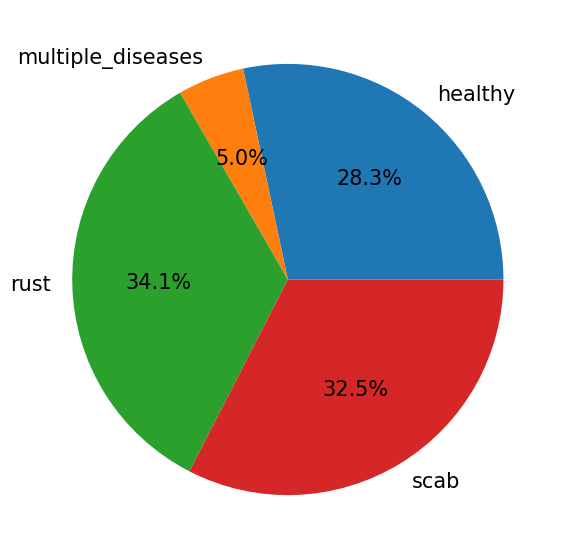

In [ ]:
show_stratified(train)

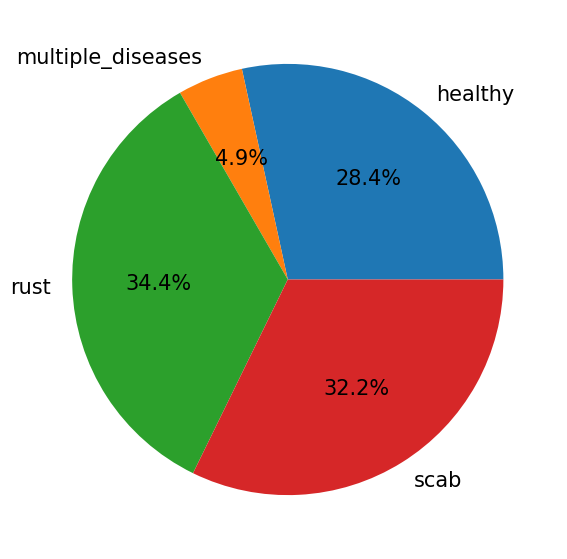

In [ ]:
show_stratified(valid)

### 데이터셋 클래스

> pytorch에서 외부 이미지로, 이미지 데이터셋을 만드는 방법을 예시코드와 함께 알려줘
* https://sharegpt.com/c/4BQVkza

> 파이썬에서 `__init__, __str__, __len__, __get_item__` 매직메소드들의 특징과 기능에 대해서 예시코드와 함께 설명해줘
* https://sharegpt.com/c/z10Hcxz

In [ ]:
from torch.utils.data import Dataset
import cv2

class ImageDataset(Dataset):
    # 초기화 메소드(생성자)
    def __init__(self,
                 df,
                 img_dir = './',
                 transform = None,
                 is_test= False,
                 # 데이터셋을 훈련용 또는 검증용 : False
                 # -> 라벨을 같이 반환
                 # 테스트용으로 만들 거면 : True
                 # -> 이미지만 반환
                 ):
        super().__init__()

        self.df = df
        self.img_dir = img_dir
        self.transform = transform
        self.is_test = is_test
        
    # 데이터셋 크기 반환 메소드
    def __len__(self): # len(...)
        return len(self.df)
    
    # 인덱스(idx)에 해당하는 데이터 반환 메소드
    def __getitem__(self, idx):
        img_id = self.df.iloc[idx, 0] # 이미지 ID (이미지 파일 이름)
        img_path = self.img_dir + img_id + '.jpg' # 이미지 파일의 전체 경로
        # ** '.jpg'가 원본에 없기 때문에 확장자 추가
        image = cv2.imread(img_path) # 이미지 파일 읽기
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # 이미지 색상 보정 (cv2 -> plt)
        # 기본 변환기 쓸 때
        # if self.transform is not None:
        #     image = self.transform(image) # 변환기(transform)가 있다면 이미지 변환
        # ** albumentations 변환기
        if self.transform is not None:
            image = self.transform(image=image)['image']
        
        # 테스트 데이터면 이미지 데이터만 반환, 그렇지 않으면 (이미지랑) 타깃값도 반환
        if self.is_test:
            return image # 테스트용일 때 이미지만.
        # 타깃값 4개 중 가장 큰 값의 인덱스 -> 1, 0, 0, 0 => 0번째
        label = np.argmax(self.df.iloc[idx, 1:5]) # 원핫인코딩 -> 라벨인코딩 (0~3)
        return image, label # 훈련/검증용일 때 이미지 & 라벨(타깃값)을 모두 리턴

> albumentations과 기존 pytorch에서의 transform 간의 차이점이 뭐야?
* https://shareg.pt/IxX7JfX

> np.argmax를 통해서 더미변수(원핫인코딩)들을 라벨인코딩으로 변경하는 방법의 원리와 예시 코드를 알려줘
* https://shareg.pt/viTjE6w

### 이미지 변환기 정의

In [ ]:
# https://albumentations.ai/docs/
# https://gaussian37.github.io/dl-pytorch-albumentation/
import albumentations as A
from albumentations.pytorch import ToTensorV2

> Vertical과 Horizontal에 대한 개념을 Pytorch에서의 flip 기준으로 설명해줘
* https://sharegpt.com/c/faDbCwW

In [ ]:
# 훈련 데이터용 변환기
transform_train = A.Compose([
    A.Resize(450, 650), # 이미지 크기 조절 
    # 밝기 대비 조절 (+- 랜덤으로 밝기 비율 조정)
    A.RandomBrightnessContrast(
        brightness_limit=0.2,
        contrast_limit=0.2, p=0.3),        
    A.VerticalFlip(p=0.2), # 상하 대칭 변환
    A.HorizontalFlip(p=0.5), # 좌우 대칭 변환 
    # 이동, 스케일링, 회전 변환
    A.ShiftScaleRotate(
        shift_limit=0.1,
        scale_limit=0.2,
        rotate_limit=30, p=0.3,
    ),
    # 양각화 (튀어나오게), 날카로움, 블러 효과
    A.OneOf([
        A.Emboss(p=1),
        A.Sharpen(p=1),
        A.Blur(p=1),
    ], p=0.3),
    # A.OneOf -> 셋 중에 하나만.
    # 어파인 변환 -> 이동, 확대/축소, 회전 => 이미지 모양을 전체적으로 바꾸는 변환기
    A.PiecewiseAffine(p=0.3),
    # 정규화 변환 
    A.Normalize(),
    # 텐서로 변환
    ToTensorV2,
])

In [ ]:
# 검증 및 테스트 데이터용 변환기
transform_test = A.Compose([
    A.Resize(450, 650), # 이미지 크기 조절 
    # 정규화 변환 
    A.Normalize(),
    # 텐서로 변환
    ToTensorV2,
])

### 데이터셋 생성

In [ ]:
# img_dir = '/kaggle/input/plant-pathology-2020-fgvc7/images/'
img_dir = 'images/'

dataset_train = ImageDataset(train, img_dir=img_dir, transform=transform_train)
dataset_valid = ImageDataset(valid, img_dir=img_dir, transform=transform_test)

In [ ]:
# 멀티 프로세싱을 위한 시드 생성
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)
    
g = torch.Generator()
g.manual_seed(0)

### 데이터로더 생성

In [ ]:
from torch.utils.data import DataLoader # 데이터 로더 클래스

batch_size = 4

loader_train = DataLoader(dataset_train, batch_size=batch_size, 
                          shuffle=True, worker_init_fn=seed_worker,
                          generator=g, num_workers=2) # 빠른 학습을 위한 멀티 프로세싱 적용
loader_valid = DataLoader(dataset_valid, batch_size=batch_size, 
                          shuffle=False, worker_init_fn=seed_worker,
                          generator=g, num_workers=2)

## 모델 생성

* (이전까지) 계층(레이어)별 구성 -> 스스로 만들었음
* (이번에는) 사전 훈련된 모델을 전이 학습시키는 것

* **사전 훈련 모델** : 이미 한 분야에서 훈련을 마친 모델
* **전이 학습** : 사전 훈련 모델을 유사한 다른 영역에서 재훈련시키는 기법

**파이토치에서 사전 훈련 모델을 이용하는 방법**
1. torchvision.models 모듈 이용
* https://pytorch.org/vision/stable/models.html
* 제공하는 모델이 많지 않음
* 기본적으로 설치되어 있기 때문에 사용하기 간단
2. pretrainedmodels 모듈 이용
* https://github.com/Cadene/pretrained-models.pytorch
* 테슬라에서 자율주행 연구하는 연구자
3. 직접 구현한 모듈 이용
* 1, 2에는 없는 모델을 사용하고 싶다면? 찾아야 함
* 구글 -> '{원하는 사전 훈련 모델} + github pytorch'

> torchvision.models로 이미지 분류기 신경망을 전이 학습하는 방법을 예시코드와 함께 설명해줘
* https://shareg.pt/MpUcKpX

> pretrainedmodels 모듈로 이미지 분류기 신경망을 전이 학습하는 방법을 예시코드와 함께 설명해줘
* https://sharegpt.com/c/VvHVLTg

> 최신 이미지 분류 모델이 사전학습된 레포지토리를, 전이학습할 수 있도록 설치 방법과 사용방법을 pytorch 기준으로 상세하기 주석과 함께 예제코드로 보여줘. (torchvision에 이미 포함되었거나, pretrainedmodels에 포함된 경우는 제외하고).
* https://sharegpt.com/c/ty3WvXp

> 최신 이미지 분류 모델이 사전학습된 모델을 전이학습할 수 있도록 설치 방법과 사용방법을 pytorch 기준으로 상세하기 주석과 함께 예제코드로 보여줘. 라이브러리 외에도 직접 레포지토리를 통해 설치하는 방법을 포함해서 (torchvision에 이미 포함되었거나, pretrainedmodels에 포함된 경우는 제외하고).
* https://sharegpt.com/c/CQx9eKV

## EfficientNet 모델 생성
* 2019년 5월, CNN

In [ ]:
!pip show efficientnet-pytorch
!pip install efficientnet-pytorch==0.7.1 -q
# https://github.com/lukemelas/EfficientNet-PyTorch

  Preparing metadata (setup.py) ... done


In [ ]:
from efficientnet_pytorch import EfficientNet # EfficientNet 모델

In [ ]:
# 1. 출력값 직접 설정
model = EfficientNet.from_pretrained('efficientnet-b7')

# 전결합 계층 -> 마지막 분류할 때 몇개로 분류할지
model._fc = nn.Sequential( # EfficientNet의 원본이 학습했던 전결합계층의 I/O features
    nn.Linear(model._fc.in_features, model._fc.out_features) # 2560 -> 1000
    nn.ReLU(), # 활성화 함수
    nn.nn.Dropout(p=0.5), # 50% 드롭아웃
    nn.Linear(model._fc.ou) # 1000 -> 4
 )

In [ ]:
# 사전 훈련된 efficientnet-b7 모델 불러오기
# 4가지 분류
# num_classes : 출력값의 개수
# 가중치, 특징맵 만드는 레이어들의 정보 가져와서 -> 우리 사정에 맞게 튜닝

# 장비 할당

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b7-dcc49843.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b7-dcc49843.pth


  0%|          | 0.00/254M [00:00<?, ?B/s]

Loaded pretrained weights for efficientnet-b7


## 모델 훈련

In [ ]:
import torch.nn as nn # 신경망 모듈

# 손실 함수
# 다중분류

In [ ]:
# 옵티마이저 : Adam -> AdamW : Adam + 가중치 감쇠 추가로 적용
# 가중치 감쇠 weight decay : 가중치를 작게 조절하는 규제 기법으로, 과적합(과대적합)을 억제해줌
# https://aimaster.tistory.com/76


In [ ]:
torch.eye(4)

tensor([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]])

In [ ]:
from sklearn.metrics import roc_auc_score # ROC AUC 점수 계산 함수
from tqdm.notebook import tqdm # 진행률 표시 막대 

epochs = 5

# 총 에폭만큼 반복
for epoch in range(epochs):
    # == [ 훈련 ] ==============================================
    model.train()        # 모델을 훈련 상태로 설정 
    epoch_train_loss = 0 # 에폭별 손실값 초기화 (훈련 데이터용)
    
    # '반복 횟수'만큼 반복 
    for images, labels in tqdm(loader_train):
        # 이미지, 레이블(타깃값) 데이터 미니배치를 장비에 할당 
        images = images.to(device)
        labels = labels.to(device)
        
        # 옵티마이저 내 기울기 초기화
        optimizer.zero_grad()
        # 순전파 : 이미지 데이터를 신경망 모델의 입력값으로 사용해 출력값 계산
        outputs = model(images)
        # 손실 함수를 활용해 outputs와 labels의 손실값 계산
        loss = criterion(outputs, labels)
        # 현재 배치에서의 손실 추가 (훈련 데이터용)
        epoch_train_loss += loss.item() 
        loss.backward() # 역전파 수행
        optimizer.step() # 가중치 갱신
    # 훈련 데이터 손실값 출력
    print(f'에폭 [{epoch+1}/{epochs}] - 훈련 데이터 손실값 : {epoch_train_loss/len(loader_train):.4f}')
    
    # == [ 검증 ] ==============================================
    model.eval()          # 모델을 평가 상태로 설정 
    epoch_valid_loss = 0  # 에폭별 손실값 초기화 (검증 데이터용)
    preds_list = []       # 예측 확률값 저장용 리스트 초기화 
    true_onehot_list = [] # 실제 타깃값 저장용 리스트 초기화 
    
    with torch.no_grad(): # 기울기 계산 비활성화
        # 미니배치 단위로 검증
        for images, labels in loader_valid:
            images = images.to(device)
            labels = labels.to(device)
            # labels -> label = np.argmax(self.df.iloc[idx, 1:5]) # 원핫인코딩 -> 라벨인코딩 (0~3)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            epoch_valid_loss += loss.item()
            
            preds = torch.softmax(outputs.cpu(), dim=1).numpy() # 예측 확률값
            '''
            tensor([[0.25, 0.25, 0.25, 0.25]])
            '''

            # 실제값 (원-핫 인코딩 형식)
            true_onehot = torch.eye(4)[labels.cpu()].cpu().numpy() # 라벨인코딩 -> 원핫인코딩
            '''
            tensor([[1., 0., 0., 0.],  <- 라벨 0
                    [0., 1., 0., 0.],  <- 라벨 1
                    [0., 0., 1., 0.],  <- 라벨 2
                    [0., 0., 0., 1.]]) <- 라벨 3
            '''
            # 예측 확률값과 실제값 저장
            preds_list.extend(preds)
            true_onehot_list.extend(true_onehot)
    # 검증 데이터 손실값 및 ROC AUC 점수 출력 
    print(f'에폭 [{epoch+1}/{epochs}] - 검증 데이터 손실값 : {epoch_valid_loss/len(loader_valid):.4f} / 검증 데이터 ROC AUC : {roc_auc_score(true_onehot_list, preds_list):.4f}')

  0%|          | 0/410 [00:00<?, ?it/s]

에폭 [1/5] - 훈련 데이터 손실값 : 0.6923
에폭 [1/5] - 검증 데이터 손실값 : 0.2763 / 검증 데이터 ROC AUC : 0.9510


  0%|          | 0/410 [00:00<?, ?it/s]

에폭 [2/5] - 훈련 데이터 손실값 : 0.3468
에폭 [2/5] - 검증 데이터 손실값 : 0.2049 / 검증 데이터 ROC AUC : 0.9637


  0%|          | 0/410 [00:00<?, ?it/s]

에폭 [3/5] - 훈련 데이터 손실값 : 0.2483
에폭 [3/5] - 검증 데이터 손실값 : 0.1692 / 검증 데이터 ROC AUC : 0.9685


  0%|          | 0/410 [00:00<?, ?it/s]

에폭 [4/5] - 훈련 데이터 손실값 : 0.1639
에폭 [4/5] - 검증 데이터 손실값 : 0.3052 / 검증 데이터 ROC AUC : 0.9695


  0%|          | 0/410 [00:00<?, ?it/s]

에폭 [5/5] - 훈련 데이터 손실값 : 0.1308
에폭 [5/5] - 검증 데이터 손실값 : 0.1480 / 검증 데이터 ROC AUC : 0.9891


In [ ]:
!ls drive/MyDrive/'Colab Notebooks'

In [ ]:
!pwd

/content


In [ ]:
# 구글 드라이브 저장
torch.save(model.state_dict(), "/content/drive/MyDrive/Colab Notebooks/plant_model1.pt")

## 예측 및 결과 제출

In [ ]:
# 테스트용 데이터셋, 데이터 로더 생성
dataset_test = ImageDataset(test, img_dir=img_dir,
                            transform=transform_test, is_test=True)
loader_test = DataLoader(
        dataset_test, batch_size=batch_size, shuffle=False,
        worker_init_fn=seed_worker, generator=g, num_workers=2 # 병렬 프로세싱 위한 코드
)

In [ ]:
# 예측
model.eval() # 평가 모드

preds = np.zeros((len(test), 4)) # 테스트 데이터셋만큼의 길이를 가지는 4열짜리 행렬 (0을 가득찬)
# preds -> 예측값 저장용 배열

with torch.no_grad(): # 테스트용이므로 기울기 계산 X
    for i, images in enumerate(loader_test): # 테스트용 데이터 로더의 각각 인덱스와 값을 받음
        images = images.to(device)
        outputs = model(images) # 모델을 거친 예측 결과
        # 타깃을 예측한 확률
        print(outputs.cpu())
        print(torch.softmax(outputs.cpu(), dim=1))
        print(torch.softmax(outputs.cpu(), dim=1).squeeze())
        preds_part = torch.softmax(outputs.cpu(), dim=1).squeeze().numpy()
        # outputs -> 신경망의 출력값이 배치 크기만큼 존재
        # -> 소프트맥스 함수 -> 확률값 (0~1) -> preds_part
        preds[i*batch_size:(i+1)*batch_size] += preds_part
        # preds 배열에, 배치 사이즈만큼 계산된 값을, 인덱스에 맞게 집어넣어줌

preds

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
        [1.3142e-06, 7.2182e-03, 9.9069e-01, 2.0952e-03]])
tensor([[2.5300e-03, 1.0098e-01, 8.9181e-01, 4.6889e-03],
        [8.8528e-04, 8.3511e-04, 6.1301e-05, 9.9822e-01],
        [1.1756e-03, 3.3865e-01, 6.5843e-01, 1.7455e-03],
        [1.3142e-06, 7.2182e-03, 9.9069e-01, 2.0952e-03]])
tensor([[-2.0327, -0.8392, -2.2698,  4.8031],
        [ 4.4902, -1.3624,  1.5813, -4.8420],
        [-1.7205, -1.7209, -2.9939,  6.0040],
        [-2.6944, -0.3162,  7.3988, -4.8198]])
tensor([[1.0687e-03, 3.5254e-03, 8.4315e-04, 9.9456e-01],
        [9.4563e-01, 2.7164e-03, 5.1571e-02, 8.3712e-05],
        [4.4143e-04, 4.4125e-04, 1.2355e-04, 9.9899e-01],
        [4.1338e-05, 4.4585e-04, 9.9951e-01, 4.9352e-06]])
tensor([[1.0687e-03, 3.5254e-03, 8.4315e-04, 9.9456e-01],
        [9.4563e-01, 2.7164e-03, 5.1571e-02, 8.3712e-05],
        [4.4143e-04, 4.4125e-04, 1.2355e-04, 9.9899e-01],
        [4.1338e-05, 4.4585e-04, 9.9951e-01, 4.9352e-06]])
tensor([[ 6.8694, -2.

array([[5.14415697e-05, 4.46291966e-03, 9.94854808e-01, 6.30864641e-04],
       [1.31436889e-06, 7.16019131e-04, 9.96610105e-01, 2.67250370e-03],
       [1.03820628e-03, 5.41194715e-03, 6.61417318e-04, 9.92888510e-01],
       ...,
       [5.91458502e-07, 1.30535138e-03, 9.98548687e-01, 1.45286293e-04],
       [9.97331858e-01, 2.14941596e-04, 4.13256566e-05, 2.41180370e-03],
       [1.39030046e-03, 3.49702388e-02, 1.08064199e-03, 9.62558866e-01]])

In [ ]:
# 이미지 ID를 제외한 컬럼들 조회
submission[submission.columns[1:]]
# 예측값을 해당 id에 맞게 집어넣어주는 코드
submission[submission.columns[1:]] = preds

In [ ]:
submission.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Test_0,5.144157e-05,0.004463,0.994855,0.000631
1,Test_1,1.314369e-06,0.000716,0.996610,0.002673
2,Test_2,1.038206e-03,0.005412,0.000661,0.992889
3,Test_3,9.998837e-01,0.000011,0.000027,0.000078
4,Test_4,8.715833e-07,0.000330,0.998819,0.000850


In [ ]:
submission.to_csv('submission.csv', index=False)

In [ ]:
files.download('submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>